# Initial set up

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import io

In [2]:
raw_df = pd.read_csv('/content/otodom_complete.csv')

In [ ]:
raw_df.shape

(3482, 30)

In [3]:
raw_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'offer_url',
       'offer_url-href', 'location', 'net_price', 'deposit', 'area',
       'room_num', 'build_type', 'floor', 'total_floor', 'build_mat',
       'windows', 'heating', 'year_built', 'status', 'agd', 'security',
       'add_info', 'rest_info', 'offer_ID', 'next_pagination',
       'next_pagination-href', 'add_cost', 'offer_last_update', 'second_page',
       'second_page-href', 'third_page', 'third_page-href'],
      dtype='object')

In [4]:
#dropping useless columns
raw_df = raw_df[['location', 'net_price',  'area',
       'room_num', 'build_type', 'build_mat','floor', 'total_floor', 
       'windows', 'heating', 'year_built', 'status', 'agd', 'security',
       'add_info', 'rest_info', 'offer_ID','add_cost','deposit',]] 

In [6]:
raw_df.reset_index(inplace=True,drop=True)
raw_df.head(2)

,location,net_price,area,room_num,build_type,build_mat,floor,total_floor,windows,heating,year_built,status,agd,security,add_info,rest_info,offer_ID,add_cost,deposit
0,"Warszawa, Włochy, ul. 1 Sierpnia",2 100 zł,Powierzchnia:37 m²,Liczba pokoi:2,NaN,NaN,Piętro:parter,Liczba pięter:4,Okna:plastikowe,NaN,NaN,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,domofon / wideofon,internet,klimatyzacja,Nr oferty w Otodom: 61451923,NaN,Kaucja:2 100 zł
1,"Warszawa, Mokotów, ul. Suwak 11",1 825 zł,Powierzchnia:38 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,Materiał budynku:pustak,Piętro:parter,NaN,Okna:plastikowe,Ogrzewanie:miejskie,Rok budowy:2020,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkapralka,domofon / wideofonmonitoring / ochrona,telewizja kablowainternet,garaż/miejsce parkingowewindapom. użytkowe,Nr oferty w Otodom: 61405987,Czynsz - dodatkowo:350 zł,Kaucja:3 400 zł


# Cleaning/Wrangling

## offer_ID

In [7]:
raw_df.offer_ID.isna().sum()

1

In [8]:
raw_df.loc[~raw_df.offer_ID.isna()]

,location,net_price,area,room_num,build_type,build_mat,floor,total_floor,windows,heating,year_built,status,agd,security,add_info,rest_info,offer_ID,add_cost,deposit
0,"Warszawa, Włochy, ul. 1 Sierpnia",2 100 zł,Powierzchnia:37 m²,Liczba pokoi:2,NaN,NaN,Piętro:parter,Liczba pięter:4,Okna:plastikowe,NaN,NaN,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,domofon / wideofon,internet,klimatyzacja,Nr oferty w Otodom: 61451923,NaN,Kaucja:2 100 zł
1,"Warszawa, Mokotów, ul. Suwak 11",1 825 zł,Powierzchnia:38 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,Materiał budynku:pustak,Piętro:parter,NaN,Okna:plastikowe,Ogrzewanie:miejskie,Rok budowy:2020,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkapralka,domofon / wideofonmonitoring / ochrona,telewizja kablowainternet,garaż/miejsce parkingowewindapom. użytkowe,Nr oferty w Otodom: 61405987,Czynsz - dodatkowo:350 zł,Kaucja:3 400 zł
2,"Warszawa, Bielany, ul. Kwitnąca",3 300 zł,Powierzchnia:57 m²,Liczba pokoi:3,Rodzaj zabudowy:blok,Materiał budynku:wielka płyta,Piętro:parter,Liczba pięter:15,Okna:drewniane,Ogrzewanie:miejskie,Rok budowy:1984,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,drzwi / okna antywłamaniowedomofon / wideofonm...,telewizja kablowainternet,balkontylko dla niepalącychoddzielna kuchnia,Nr oferty w Otodom: 61375474,Czynsz - dodatkowo:1 zł,Kaucja:3 300 zł
3,"Warszawa, Targówek, ul. św. Wincentego",2 200 zł,Powierzchnia:63 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,Materiał budynku:cegła,Piętro:4,Liczba pięter:5,Okna:drewniane,Ogrzewanie:miejskie,Rok budowy:2005,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,teren zamkniętydomofon / wideofonmonitoring / ...,balkon,NaN,Nr oferty w Otodom: 61439492,NaN,NaN
4,"Warszawa, Ochota, Stara Ochota, ul. Juliana Ur...",3 000 zł,Powierzchnia:65 m²,Liczba pokoi:3,Rodzaj zabudowy:kamienica,Materiał budynku:cegła,Piętro:3,Liczba pięter:4,Okna:plastikowe,Ogrzewanie:miejskie,Rok budowy:1938,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkapralka,drzwi / okna antywłamanioweteren zamkniętydomo...,piwnicawindatylko dla niepalącychoddzielna kuc...,NaN,Nr oferty w Otodom: 61455072,NaN,Kaucja:3 000 zł
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477,"Warszawa, Praga-Południe, Saska Kępa, pl. Plac...",2 000 zł,Powierzchnia:45 m²,Liczba pokoi:1,Rodzaj zabudowy:apartamentowiec,NaN,Piętro:3,Liczba pięter:7,NaN,NaN,NaN,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,monitoring / ochrona,telewizja kablowainternettelefon,winda,Nr oferty w Otodom: 61536131,Czynsz - dodatkowo:350 zł,Kaucja:2 500 zł
3478,"Warszawa, Wilanów",3 300 zł,Powierzchnia:50 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,Materiał budynku:cegła,Piętro:1,Liczba pięter:2,Okna:plastikowe,Ogrzewanie:miejskie,Rok budowy:2006,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,drzwi / okna antywłamanioweteren zamkniętydomo...,telewizja kablowainternet,balkonpiwnicagaraż/miejsce parkingowepom. użyt...,Nr oferty w Otodom: 61535357,NaN,Kaucja:3 000 zł
3479,"Warszawa, Praga-Południe, Gocław, ul. Jana Now...",2 500 zł,"Powierzchnia:46,66 m²",Liczba pokoi:2,Rodzaj zabudowy:apartamentowiec,Materiał budynku:cegła,Piętro:5,Liczba pięter:5,Okna:plastikowe,Ogrzewanie:miejskie,Rok budowy:2015,Stan wykończenia:do zamieszkania,zmywarkalodówkameblepiekarnikkuchenkatelewizor...,teren zamkniętydomofon / wideofonmonitoring / ...,telewizja kablowainternettelefon,balkongaraż/miejsce parkingowewindatylko dla n...,Nr oferty w Otodom: 61535028,NaN,Kaucja:2 500 zł
3480,"Warszawa, Praga-Północ, ul. Łochowska",1 300 zł,Powierzchnia:23 m²,Liczba pokoi:1,Rodzaj zabudowy:kamienica,Materiał budynku:cegła,Piętro:parter,Liczba pięter:4,Okna:drewniane,Ogrzewanie:kotłownia,Rok budowy:1938,Stan wykończenia:do zamieszkania,lodówkameblepralka,drzwi / okna antywłamaniowe,internet,tylko dla niepalących

## location

### Missing Values

In [9]:
raw_df.isna().sum()

location          1
net_price         1
area              1
room_num          1
build_type      143
build_mat      1243
floor            81
total_floor     437
windows         583
heating         484
year_built     1014
status          291
agd              47
security         90
add_info        292
rest_info      1470
offer_ID          1
add_cost       1567
deposit         336
dtype: int64

In [10]:
raw_df.loc[raw_df.location.isna()].head()

,location,net_price,area,room_num,build_type,build_mat,floor,total_floor,windows,heating,year_built,status,agd,security,add_info,rest_info,offer_ID,add_cost,deposit
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#seems like these pages won't be usefull at all s o we drop them
raw_df = raw_df.loc[~raw_df.location.isna()]

### Feature engeneering

In [12]:
raw_df.location[0]

'Warszawa, Włochy, ul. 1 Sierpnia'

In [13]:
#create a feature with separeted location(by comma)
raw_df['location_chunks'] = raw_df.location.str.split(',')

#create new features(district, street)
raw_df['district'] = raw_df.location_chunks.str[1]
raw_df.drop('location_chunks', axis=1, inplace=True)

In [14]:
raw_df.district.value_counts()

 Mokotów             647
 Wola                512
 Śródmieście         347
 Praga-Południe      240
 Ursynów             205
 Ochota              201
 Bielany             166
 Bemowo              155
 Białołęka           155
 Praga-Północ        135
 Wilanów             125
 Targówek            116
 Żoliborz            105
 Ursus                97
 Włochy               77
 Centrum              63
 mazowieckie          44
 Wawer                42
 Warszawa             19
 Rembertów            14
 Wesoła               14
 Metro Wilanowska      2
Name: district, dtype: int64

## net_price

In [15]:
#checking currencies
currency = []
for j in raw_df.net_price:
  currency.append(''.join(x for x in j if x.isalpha()))
raw_df['currency'] = currency
raw_df.currency.unique()

array(['zł'], dtype=object)

In [16]:
# run in case there are other currencies present
raw_df = raw_df.loc[raw_df.currency == 'zł']
raw_df.drop('currency', axis=1, inplace=True)

In [17]:
price = []
for j in raw_df.net_price:
  j =j.replace(',', '.') #in case there are incorrect float prices with ',' instead of '.'
  j = int(''.join(i for i in j if i.isdigit()))
  j=int(j)
  price.append(j)
raw_df.net_price = price

### outliers

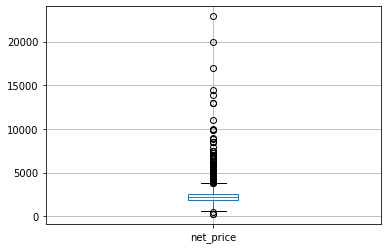

In [18]:
raw_df.boxplot(column=['net_price'])

In [19]:
raw_df = raw_df.loc[raw_df.net_price <= 10000]

## deposit	

In [20]:
raw_df.deposit.fillna('Kaucja:0 zł', inplace=True)

In [21]:
raw_df.deposit

0       Kaucja:2 100 zł
1       Kaucja:3 400 zł
2       Kaucja:3 300 zł
3           Kaucja:0 zł
4       Kaucja:3 000 zł
             ...       
3477    Kaucja:2 500 zł
3478    Kaucja:3 000 zł
3479    Kaucja:2 500 zł
3480    Kaucja:1 700 zł
3481    Kaucja:2 500 zł
Name: deposit, Length: 3473, dtype: object

In [22]:
deposit = []
for j in raw_df.deposit:
  j =j.split(":",1)[1] 
  j =j.replace(' zł', '')
  j =j.replace(' ', '')
  j =j.replace(',', '.')
  j=float(j)
  j=int(j)
  deposit.append(j)
raw_df.deposit = deposit

In [23]:
raw_df.loc[raw_df.deposit == 0, 'deposit'] = raw_df.net_price

## add_cost

In [24]:
raw_df.add_cost.fillna('Czynsz - dodatkowo:0 zł', inplace=True)

In [25]:
add_cost = []
for j in raw_df.add_cost:
  j =j.split(":",1)[1] 
  j =j.replace(' zł', '')
  j =j.replace(' ', '')
  j =j.replace(',', '.')
  j=float(j)
  j=int(j)
  add_cost.append(j)
raw_df.add_cost = add_cost

In [26]:
raw_df.loc[raw_df.add_cost == 0, 'add_cost']=np.NaN 
raw_df.loc[raw_df.add_cost == 1, 'add_cost']= 0

## area

In [27]:
raw_df.area

0          Powierzchnia:37 m²
1          Powierzchnia:38 m²
2          Powierzchnia:57 m²
3          Powierzchnia:63 m²
4          Powierzchnia:65 m²
                ...          
3477       Powierzchnia:45 m²
3478       Powierzchnia:50 m²
3479    Powierzchnia:46,66 m²
3480       Powierzchnia:23 m²
3481       Powierzchnia:41 m²
Name: area, Length: 3473, dtype: object

In [28]:
area = []
for j in raw_df.area:
  j =j.split(":",1)[1] 
  j =j.replace(' m²', '')
  j =j.replace(' ', '')
  j =j.replace(',', '.')
  j=float(j)
  j=int(j)
  area.append(j)
raw_df.area = area

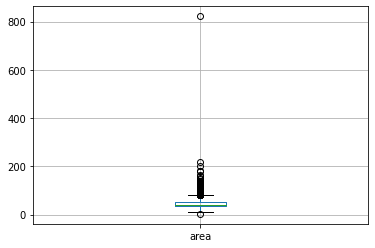

In [29]:
raw_df.boxplot(column=['area'])

In [30]:
raw_df = raw_df.loc[raw_df.area <=250]

## room_num

In [31]:
raw_df.room_num

0       Liczba pokoi:2
1       Liczba pokoi:2
2       Liczba pokoi:3
3       Liczba pokoi:2
4       Liczba pokoi:3
             ...      
3477    Liczba pokoi:1
3478    Liczba pokoi:2
3479    Liczba pokoi:2
3480    Liczba pokoi:1
3481    Liczba pokoi:2
Name: room_num, Length: 3472, dtype: object

In [32]:
raw_df.room_num.value_counts()

Liczba pokoi:2    1990
Liczba pokoi:1     834
Liczba pokoi:3     533
Liczba pokoi:4      98
Liczba pokoi:5      15
Liczba pokoi:6       1
Liczba pokoi:7       1
Name: room_num, dtype: int64

In [33]:
room_num = []
for j in raw_df.room_num:
  j =j.split(":",1)[1] 
  j=int(j)
  room_num.append(j)
raw_df.room_num = room_num

## build_type	

In [34]:
raw_df.build_type.isna().sum()

142

In [35]:
raw_df.build_type	

0                                   NaN
1                  Rodzaj zabudowy:blok
2                  Rodzaj zabudowy:blok
3                  Rodzaj zabudowy:blok
4             Rodzaj zabudowy:kamienica
                     ...               
3477    Rodzaj zabudowy:apartamentowiec
3478               Rodzaj zabudowy:blok
3479    Rodzaj zabudowy:apartamentowiec
3480          Rodzaj zabudowy:kamienica
3481               Rodzaj zabudowy:blok
Name: build_type, Length: 3472, dtype: object

In [36]:
raw_df.build_type.value_counts()

Rodzaj zabudowy:blok                1837
Rodzaj zabudowy:apartamentowiec     1036
Rodzaj zabudowy:kamienica            418
Rodzaj zabudowy:dom wolnostojący      22
Rodzaj zabudowy:szeregowiec           10
Rodzaj zabudowy:loft                   4
Rodzaj zabudowy:plomba                 3
Name: build_type, dtype: int64

In [37]:
#subset without na
build_df = raw_df.loc[~raw_df.build_type.isna()]

#getting the useful part of data
build_type = []
for j in build_df.build_type:
  j =j.split(":",1)[1] 
  build_type.append(j)
build_df.build_type = build_type

#dict for mapping
keys = build_df.offer_ID
vals = build_df.build_type
build_zip = dict(zip(keys, vals))

raw_df.build_type = raw_df.offer_ID
raw_df.build_type = raw_df.build_type.map(build_zip)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
raw_df.build_type.value_counts()

blok                1837
apartamentowiec     1036
kamienica            418
dom wolnostojący      22
szeregowiec           10
loft                   4
plomba                 3
Name: build_type, dtype: int64

In [39]:
#translation
raw_df.loc[raw_df.build_type == 'blok', 'build_type'] = 'Apartment_medium_q(blok)'
raw_df.loc[raw_df.build_type == 'apartamentowiec', 'build_type'] = 'Apartment_high_q(apartamentowiec)'
raw_df.loc[raw_df.build_type == 'kamienica', 'build_type'] = 'Tenement(kamienica)'
raw_df.loc[raw_df.build_type == 'dom wolnostojący', 'build_type'] = 'Private_house_1_fam(dom wolnostojący)'
raw_df.loc[raw_df.build_type == 'szeregowiec', 'build_type'] = 'Private_house_1+_fam(szeregowiec)'
raw_df.loc[raw_df.build_type == 'loft', 'build_type'] = 'Loft/attic(loft)'
raw_df.loc[raw_df.build_type == 'plomba', 'build_type'] = 'Infill(plomba)'

## build_mat	

In [40]:
raw_df.build_mat.isna().sum()

1239

In [41]:
#subset without na
build_mat_df = raw_df.loc[~raw_df.build_mat.isna()]

#getting the useful part of data
build_mat = []
for j in build_mat_df.build_mat:
  j =j.split(":",1)[1] 
  build_mat.append(j)

build_mat_df.build_mat = build_mat

#dict for mapping
keys1 = build_mat_df.offer_ID
vals1 = build_mat_df.build_mat
build_mat_zip = dict(zip(keys1, vals1))

raw_df.build_mat = raw_df.offer_ID
raw_df.build_mat = raw_df.build_mat.map(build_mat_zip)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
raw_df.build_mat.value_counts()

cegła              1450
wielka płyta        241
inne                127
żelbet              123
pustak               99
beton                94
beton komórkowy      56
silikat              39
keramzyt              2
drewno                2
Name: build_mat, dtype: int64

In [43]:
#translation
raw_df.loc[raw_df.build_mat == 'cegła', 'build_mat'] = 'Brick(cegła)'
raw_df.loc[raw_df.build_mat == 'wielka płyta', 'build_mat'] = 'Conreate_slab(wielka_płyta)'
raw_df.loc[raw_df.build_mat == 'inne', 'build_mat'] = 'Other(inne)'
raw_df.loc[raw_df.build_mat == 'żelbet', 'build_mat'] = 'Reinforced_concrete(żelbet)'
raw_df.loc[raw_df.build_mat == 'pustak', 'build_mat'] = 'Concrete_masonry_unit(pustak)'
raw_df.loc[raw_df.build_mat == 'beton', 'build_mat'] = 'Concreate(beton)'
raw_df.loc[raw_df.build_mat == 'beton komórkowy', 'build_mat'] = 'Autoclaved_aerated_concrete(beton_komórkowy)'
raw_df.loc[raw_df.build_mat == 'silikat', 'build_mat'] = 'Silicate brick(silikat)'
raw_df.loc[raw_df.build_mat == 'drewno', 'build_mat'] = 'Wood(drewno)'
raw_df.loc[raw_df.build_mat == 'keramzyt', 'build_mat'] = 'Expanded_clay(keramzyt)'

## total_floor

In [44]:
raw_df.total_floor.isna().sum()

436

In [45]:
raw_df.total_floor

0        Liczba pięter:4
1                    NaN
2       Liczba pięter:15
3        Liczba pięter:5
4        Liczba pięter:4
              ...       
3477     Liczba pięter:7
3478     Liczba pięter:2
3479     Liczba pięter:5
3480     Liczba pięter:4
3481     Liczba pięter:6
Name: total_floor, Length: 3472, dtype: object

In [46]:
#subset without na
total_floor_df = raw_df.loc[~raw_df.total_floor.isna()]

#getting the useful part of data
total_floor = []
for j in total_floor_df.total_floor:
  j =j.split(":",1)[1] 
  j=int(j)
  total_floor.append(j)

total_floor_df.total_floor = total_floor

#dict for mapping
keys2 = total_floor_df.offer_ID
vals2 = total_floor_df.total_floor
total_floor_zip = dict(zip(keys2, vals2))

raw_df.total_floor = raw_df.offer_ID
raw_df.total_floor = raw_df.total_floor.map(total_floor_zip)

raw_df.total_floor.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


4.0     617
6.0     387
3.0     343
5.0     314
10.0    301
7.0     261
8.0     234
2.0     130
15.0     86
11.0     85
9.0      77
12.0     74
1.0      28
14.0     28
17.0     19
13.0     17
16.0     15
22.0      6
19.0      3
30.0      3
25.0      2
20.0      2
21.0      1
18.0      1
24.0      1
23.0      1
Name: total_floor, dtype: int64

## floor

In [47]:
raw_df.floor.isna().sum()

80

In [48]:
#subset without na
floor_df = raw_df.loc[~raw_df.floor.isna()]

#getting the useful part of data
floor = []
for j in floor_df.floor:
  j =j.split(":",1)[1] 
  if j == 'parter':
    j=1.0
  if j == '> 10':
    j=11.0
  if j == 'suterena':
    j=0
  if j == 'poddasze':
    j=j
  else:
    j=float(j)
  floor.append(j)

floor_df.floor = floor

#dict for mapping
keys3 = floor_df.offer_ID
vals3 = floor_df.floor
floor_zip = dict(zip(keys3, vals3))

raw_df.floor = raw_df.offer_ID
raw_df.floor = raw_df.floor.map(floor_zip)

raw_df.floor.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1.0         945
2.0         600
3.0         517
4.0         368
5.0         265
6.0         204
7.0         134
8.0         111
11.0         86
9.0          80
10.0         71
poddasze      7
0.0           4
Name: floor, dtype: int64

In [49]:
raw_df['poddasze'] = 0

raw_df.loc[raw_df.floor == 'poddasze', 'poddasze'] = 1
raw_df.loc[raw_df.floor == 'poddasze', 'floor'] = raw_df.total_floor

raw_df.floor.value_counts()

1.0     945
2.0     604
3.0     517
4.0     369
5.0     265
6.0     205
7.0     134
8.0     111
11.0     86
9.0      80
10.0     71
0.0       4
15.0      1
Name: floor, dtype: int64

In [50]:
data_types_dict = {'floor': float} 
raw_df = raw_df.astype(data_types_dict) 
raw_df.floor

0       1.0
1       1.0
2       1.0
3       4.0
4       3.0
       ... 
3477    3.0
3478    1.0
3479    5.0
3480    1.0
3481    1.0
Name: floor, Length: 3472, dtype: float64

## windows

In [51]:
raw_df.windows.isna().sum()

580

In [52]:
#subset without na
windows_df = raw_df.loc[~raw_df.windows.isna()]

#getting the useful part of data
windows = []
for j in windows_df.windows:
  j =j.split(":",1)[1] 
  windows.append(j)

windows_df.windows = windows

#dict for mapping
keys4 = windows_df.offer_ID
vals4 = windows_df.windows
windows_zip = dict(zip(keys4, vals4))

raw_df.windows = raw_df.offer_ID
raw_df.windows = raw_df.windows.map(windows_zip)
raw_df.windows.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


plastikowe    2148
drewniane      708
aluminiowe      36
Name: windows, dtype: int64

In [53]:
#translation
raw_df.loc[raw_df.windows == 'plastikowe', 'windows'] = 'Plastic(plastikowe)'
raw_df.loc[raw_df.windows == 'drewniane', 'windows'] = 'Wooden(drewniane)'
raw_df.loc[raw_df.windows == 'aluminiowe', 'windows'] = 'Aluminum(aluminiowe)'

## heating

In [54]:
raw_df.heating.isna().sum()

482

In [55]:
#subset without na
heating_df = raw_df.loc[~raw_df.heating.isna()]

#getting the useful part of data
heating = []
for j in heating_df.heating:
  j =j.split(":",1)[1] 
  heating.append(j)

heating_df.heating = heating

#dict for mapping
keys4 = heating_df.offer_ID
vals4 = heating_df.heating
heating_zip = dict(zip(keys4, vals4))

raw_df.heating = raw_df.offer_ID
raw_df.heating = raw_df.heating.map(heating_zip)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [56]:
raw_df.heating.value_counts()

miejskie       2775
gazowe          109
kotłownia        68
elektryczne      22
inne             16
Name: heating, dtype: int64

In [57]:
#translation
raw_df.loc[raw_df.heating == 'miejskie', 'heating'] = 'Central(miejskie)'
raw_df.loc[raw_df.heating == 'gazowe', 'heating'] = 'Gas(gazowe)'
raw_df.loc[raw_df.heating == 'elektryczne', 'heating'] = 'Electric(elektryczne)'
raw_df.loc[raw_df.heating == 'inne', 'heating'] = 'Other(inne)'
raw_df.loc[raw_df.heating == 'kotłownia', 'heating'] = 'Boiler(kotłownia)'

## year_built

In [58]:
raw_df.year_built.isna().sum()

1010

In [59]:
raw_df.year_built

0                   NaN
1       Rok budowy:2020
2       Rok budowy:1984
3       Rok budowy:2005
4       Rok budowy:1938
             ...       
3477                NaN
3478    Rok budowy:2006
3479    Rok budowy:2015
3480    Rok budowy:1938
3481    Rok budowy:1990
Name: year_built, Length: 3472, dtype: object

In [60]:
#subset without na
year_built_df = raw_df.loc[~raw_df.year_built.isna()]

#getting the useful part of data
year_built = []
for j in year_built_df.year_built:
  j =j.split(":",1)[1] 
  j=int(j)
  year_built.append(j)

year_built_df.year_built = year_built

#dict for mapping
keys2 = year_built_df.offer_ID
vals2 = year_built_df.year_built
year_built_zip = dict(zip(keys2, vals2))

raw_df.year_built = raw_df.offer_ID
raw_df.year_built = raw_df.year_built.map(year_built_zip)

raw_df.year_built.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


2020.0    334
2019.0    164
2018.0    129
2017.0    116
2008.0     93
         ... 
1948.0      1
75.0        1
1993.0      1
1915.0      1
1923.0      1
Name: year_built, Length: 115, dtype: int64

In [61]:
raw_df.loc[(raw_df.year_built >= 100)&(raw_df.year_built < 1700), 'year_built'] = np.NaN
raw_df.loc[raw_df.year_built < 100, 'year_built'] = raw_df.year_built+1900

## status

In [62]:
raw_df.status.isna().sum()

289

In [63]:
raw_df.status.value_counts()

Stan wykończenia:do zamieszkania    3175
Stan wykończenia:do wykończenia        6
Stan wykończenia:do remontu            2
Name: status, dtype: int64

In [64]:
#subset without na
status_df = raw_df.loc[~raw_df.status.isna()]

#getting the useful part of data
status = []
for j in status_df.status:
  j =j.split(":",1)[1] 
  status.append(j)

status_df.status = status

#dict for mapping
keys4 = status_df.offer_ID
vals4 = status_df.status
status_zip = dict(zip(keys4, vals4))

raw_df.status = raw_df.offer_ID
raw_df.status = raw_df.status.map(status_zip)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [65]:
raw_df.status.value_counts()

do zamieszkania    3175
do wykończenia        6
do remontu            2
Name: status, dtype: int64

In [66]:
#translation
raw_df.loc[raw_df.status == 'do zamieszkania', 'status'] = 'Ready(do_zamieszkania)'
raw_df.loc[raw_df.status == 'do wykończenia', 'status'] = 'Not_ready_yet(do_wykończenia)'
raw_df.loc[raw_df.status == 'do remontu', 'status'] = 'Renovation(do remontu)'

## extra features

In [67]:
raw_df['extra_features'] = raw_df.agd.astype('str') + raw_df.security.astype('str')  + raw_df.add_info.astype('str') + raw_df.rest_info.astype('str')

In [68]:
raw_df.head(2)

,location,net_price,area,room_num,build_type,build_mat,floor,total_floor,windows,heating,year_built,status,agd,security,add_info,rest_info,offer_ID,add_cost,deposit,district,poddasze,extra_features
0,"Warszawa, Włochy, ul. 1 Sierpnia",2100,37,2,NaN,NaN,1.0,4.0,Plastic(plastikowe),NaN,NaN,Ready(do_zamieszkania),zmywarkalodówkameblepiekarnikkuchenkatelewizor...,domofon / wideofon,internet,klimatyzacja,Nr oferty w Otodom: 61451923,NaN,2100,Włochy,0,zmywarkalodówkameblepiekarnikkuchenkatelewizor...
1,"Warszawa, Mokotów, ul. Suwak 11",1825,38,2,Apartment_medium_q(blok),Concrete_masonry_unit(pustak),1.0,NaN,Plastic(plastikowe),Central(miejskie),2020.0,Ready(do_zamieszkania),zmywarkalodówkameblepiekarnikkuchenkapralka,domofon / wideofonmonitoring / ochrona,telewizja kablowainternet,garaż/miejsce parkingowewindapom. użytkowe,Nr oferty w Otodom: 61405987,350.0,3400,Mokotów,0,zmywarkalodówkameblepiekarnikkuchenkapralkadom...


In [69]:
extra = ['dish_washer(zmywarka)','fridge(lodówka)','furniture(meble)','oven(piekarnik)','stove(kuchenka)','tv_set(telewizor)',
         'washer(pralka)','secure_doors/windows(drzwi/okna_antywłamaniowe)','intercom/videophone(domofon/wideofon)',
         'monitoring/security(monitoring/ochrona)','closed_area(teren_zamknięty)','balcony(balkon)','basement(piwnica)',
         'garage/parking_space(garaż/miejsce_parkingowe)', 'alarm system(system alarmowy)','only_for_non-smokers(tylko_dla_niepalących)','anti-burglary blinds(rolety antywłamaniowe)',
         'elevator(winda)', 'separate kitchen(oddzielna kuchnia)','internet','cable TV(telewizja kablowa)','telephone(telefon)','air conditioning(klimatyzacja)',
         'available for students(wynajmę również studentom)','utility room(pom. użytkowe)', 'terrace(taras)','two-level(dwupoziomowe)', 'garden(ogródek)']

In [70]:
for i in extra:
  raw_df[i] = raw_df.extra_features

In [71]:
raw_df['dish_washer(zmywarka)'] = raw_df['dish_washer(zmywarka)'].str.replace(r'(^.*zmywarka.*$)', '1')
raw_df['fridge(lodówka)'] = raw_df['fridge(lodówka)'].str.replace(r'(^.*lodówka.*$)', '1')
raw_df['furniture(meble)'] = raw_df['furniture(meble)'].str.replace(r'(^.*meble.*$)', '1')
raw_df['oven(piekarnik)'] = raw_df['oven(piekarnik)'].str.replace(r'(^.*piekarnik.*$)', '1')
raw_df['stove(kuchenka)'] = raw_df['stove(kuchenka)'].str.replace(r'(^.*kuchenka.*$)', '1')
raw_df['tv_set(telewizor)'] = raw_df['tv_set(telewizor)'].str.replace(r'(^.*telewizor.*$)', '1')
raw_df['washer(pralka)'] = raw_df['washer(pralka)'].str.replace(r'(^.*pralka.*$)', '1')
raw_df['intercom/videophone(domofon/wideofon)'] = raw_df['intercom/videophone(domofon/wideofon)'].str.replace(r'(^.*domofon/wideofon.*$)', '1')
raw_df['secure_doors/windows(drzwi/okna_antywłamaniowe)'] = raw_df['secure_doors/windows(drzwi/okna_antywłamaniowe)'].str.replace(r'(^.*drzwi/okna antywłamaniowe.*$)', '1')
raw_df['monitoring/security(monitoring/ochrona)'] = raw_df['monitoring/security(monitoring/ochrona)'].str.replace(r'(^.*monitoring/security(monitoring/ochrona).*$)', '1')
raw_df['closed_area(teren_zamknięty)'] = raw_df['closed_area(teren_zamknięty)'].str.replace(r'(^.*teren_zamknięty.*$)', '1')
raw_df['balcony(balkon)'] = raw_df['balcony(balkon)'].str.replace(r'(^.*balkon.*$)', '1')
raw_df['basement(piwnica)'] = raw_df['basement(piwnica)'].str.replace(r'(^.*piwnica.*$)', '1')
raw_df['elevator(winda)'] = raw_df['elevator(winda)'].str.replace(r'(^.*winda.*$)', '1')
raw_df['garage/parking_space(garaż/miejsce_parkingowe)'] = raw_df['garage/parking_space(garaż/miejsce_parkingowe)'].str.replace(r'(^.*garaż/miejsce_parkingowe.*$)', '1')
raw_df['alarm system(system alarmowy)'] = raw_df['alarm system(system alarmowy)'].str.replace(r'(^.*system alarmowy.*$)', '1')
raw_df['only_for_non-smokers(tylko_dla_niepalących)'] = raw_df['only_for_non-smokers(tylko_dla_niepalących)'].str.replace(r'(^.*tylko_dla_niepalących.*$)', '1')
raw_df['anti-burglary blinds(rolety antywłamaniowe)'] = raw_df['anti-burglary blinds(rolety antywłamaniowe)'].str.replace(r'(^.*rolety antywłamaniowe.*$)', '1')
raw_df['separate kitchen(oddzielna kuchnia)'] = raw_df['separate kitchen(oddzielna kuchnia)'].str.replace(r'(^.*oddzielna kuchnia.*$)', '1')
raw_df.internet = raw_df.internet.str.replace(r'(^.*internet.*$)', '1')
raw_df['cable TV(telewizja kablowa)'] = raw_df['cable TV(telewizja kablowa)'].str.replace(r'(^.*telewizja kablowa.*$)', '1')
raw_df['telephone(telefon)'] = raw_df['telephone(telefon)'].str.replace(r'(^.*telefon.*$)', '1')
raw_df['air conditioning(klimatyzacja)'] = raw_df['air conditioning(klimatyzacja)'].str.replace(r'(^.*klimatyzacja.*$)', '1')
raw_df['available for students(wynajmę również studentom)'] = raw_df['available for students(wynajmę również studentom)'].str.replace(r'(^.*wynajmę również studentom.*$)', '1')
raw_df['utility room(pom. użytkowe)'] = raw_df['utility room(pom. użytkowe)'].str.replace(r'(^.*pom. użytkowe.*$)', '1')
raw_df['terrace(taras)'] = raw_df['terrace(taras)'].str.replace(r'(^.*taras.*$)', '1')
raw_df['two-level(dwupoziomowe)'] = raw_df['two-level(dwupoziomowe)'].str.replace(r'(^.*dwupoziomowe.*$)', '1')
raw_df['garden(ogródek)'] = raw_df['garden(ogródek)'].str.replace(r'(^.*ogródek.*$)', '1')

In [72]:
for i in extra:
  raw_df.loc[raw_df[i] == raw_df.extra_features, i] = 0

In [73]:
raw_df.drop(['location','agd','security', 'add_info','rest_info', 'offer_ID','extra_features'],axis=1, inplace=True)

# Imputation

In [74]:
raw_df.isna().sum()

net_price                                               0
area                                                    0
room_num                                                0
build_type                                            142
build_mat                                            1239
floor                                                  80
total_floor                                           436
windows                                               580
heating                                               482
year_built                                           1011
status                                                289
add_cost                                             1562
deposit                                                 0
district                                                0
poddasze                                                0
dish_washer(zmywarka)                                   0
fridge(lodówka)                                         0
furniture(mebl

## Encoding

In [79]:
data_types_dict2 = dict()
for i in extra:
  data_types_dict2[i] = int
data_types_dict2['poddasze'] = int 
raw_df = raw_df.astype(data_types_dict2) 

In [80]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3472 entries, 0 to 3481
Data columns (total 43 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   net_price                                          3472 non-null   int64  
 1   area                                               3472 non-null   int64  
 2   room_num                                           3472 non-null   int64  
 3   build_type                                         3330 non-null   object 
 4   build_mat                                          2233 non-null   object 
 5   floor                                              3392 non-null   float64
 6   total_floor                                        3036 non-null   float64
 7   windows                                            2892 non-null   object 
 8   heating                                            2990 non-null   object 
 9   year_bui

In [81]:
df = pd.get_dummies(raw_df, columns=["build_type",'build_mat','windows','heating','status','district'])

In [82]:
df.head()

,net_price,area,room_num,floor,total_floor,year_built,add_cost,deposit,poddasze,dish_washer(zmywarka),fridge(lodówka),furniture(meble),oven(piekarnik),stove(kuchenka),tv_set(telewizor),washer(pralka),secure_doors/windows(drzwi/okna_antywłamaniowe),intercom/videophone(domofon/wideofon),monitoring/security(monitoring/ochrona),closed_area(teren_zamknięty),balcony(balkon),basement(piwnica),garage/parking_space(garaż/miejsce_parkingowe),alarm system(system alarmowy),only_for_non-smokers(tylko_dla_niepalących),anti-burglary blinds(rolety antywłamaniowe),elevator(winda),separate kitchen(oddzielna kuchnia),internet,cable TV(telewizja kablowa),telephone(telefon),air conditioning(klimatyzacja),available for students(wynajmę również studentom),utility room(pom. użytkowe),terrace(taras),two-level(dwupoziomowe),garden(ogródek),build_type_Apartment_high_q(apartamentowiec),build_type_Apartment_medium_q(blok),build_type_Infill(plomba),...,build_mat_Concrete_masonry_unit(pustak),build_mat_Conreate_slab(wielka_płyta),build_mat_Expanded_clay(keramzyt),build_mat_Other(inne),build_mat_Reinforced_concrete(żelbet),build_mat_Silicate brick(silikat),build_mat_Wood(drewno),windows_Aluminum(aluminiowe),windows_Plastic(plastikowe),windows_Wooden(drewniane),heating_Boiler(kotłownia),heating_Central(miejskie),heating_Electric(elektryczne),heating_Gas(gazowe),heating_Other(inne),status_Not_ready_yet(do_wykończenia),status_Ready(do_zamieszkania),status_Renovation(do remontu),district_ Bemowo,district_ Białołęka,district_ Bielany,district_ Centrum,district_ Metro Wilanowska,district_ Mokotów,district_ Ochota,district_ Praga-Południe,district_ Praga-Północ,district_ Rembertów,district_ Targówek,district_ Ursus,district_ Ursynów,district_ Warszawa,district_ Wawer,district_ Wesoła,district_ Wilanów,district_ Wola,district_ Włochy,district_ mazowieckie,district_ Śródmieście,district_ Żoliborz
0,2100,37,2,1.0,4.0,NaN,NaN,2100,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1825,38,2,1.0,NaN,2020.0,350.0,3400,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3300,57,3,1.0,15.0,1984.0,0.0,3300,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2200,63,2,4.0,5.0,2005.0,NaN,2200,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3000,65,3,3.0,4.0,1938.0,NaN,3000,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Imputing

In [83]:
add_price_df = df[['area','room_num','floor','year_built', 'net_price', 'deposit', 'add_cost']]
add_price_df

,area,room_num,floor,year_built,net_price,deposit,add_cost
0,37,2,1.0,NaN,2100,2100,NaN
1,38,2,1.0,2020.0,1825,3400,350.0
2,57,3,1.0,1984.0,3300,3300,0.0
3,63,2,4.0,2005.0,2200,2200,NaN
4,65,3,3.0,1938.0,3000,3000,NaN
...,...,...,...,...,...,...,...
3477,45,1,3.0,NaN,2000,2500,350.0
3478,50,2,1.0,2006.0,3300,3000,NaN
3479,46,2,5.0,2015.0,2500,2500,NaN
3480,23,1,1.0,1938.0,1300,1700,270.0


In [84]:
df.isna().sum()

net_price                  0
area                       0
room_num                   0
floor                     80
total_floor              436
                        ... 
district_ Wola             0
district_ Włochy           0
district_ mazowieckie      0
district_ Śródmieście      0
district_ Żoliborz         0
Length: 87, dtype: int64

In [85]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=86)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
df.sample(5)

,net_price,area,room_num,floor,total_floor,year_built,add_cost,deposit,poddasze,dish_washer(zmywarka),fridge(lodówka),furniture(meble),oven(piekarnik),stove(kuchenka),tv_set(telewizor),washer(pralka),secure_doors/windows(drzwi/okna_antywłamaniowe),intercom/videophone(domofon/wideofon),monitoring/security(monitoring/ochrona),closed_area(teren_zamknięty),balcony(balkon),basement(piwnica),garage/parking_space(garaż/miejsce_parkingowe),alarm system(system alarmowy),only_for_non-smokers(tylko_dla_niepalących),anti-burglary blinds(rolety antywłamaniowe),elevator(winda),separate kitchen(oddzielna kuchnia),internet,cable TV(telewizja kablowa),telephone(telefon),air conditioning(klimatyzacja),available for students(wynajmę również studentom),utility room(pom. użytkowe),terrace(taras),two-level(dwupoziomowe),garden(ogródek),build_type_Apartment_high_q(apartamentowiec),build_type_Apartment_medium_q(blok),build_type_Infill(plomba),...,build_mat_Concrete_masonry_unit(pustak),build_mat_Conreate_slab(wielka_płyta),build_mat_Expanded_clay(keramzyt),build_mat_Other(inne),build_mat_Reinforced_concrete(żelbet),build_mat_Silicate brick(silikat),build_mat_Wood(drewno),windows_Aluminum(aluminiowe),windows_Plastic(plastikowe),windows_Wooden(drewniane),heating_Boiler(kotłownia),heating_Central(miejskie),heating_Electric(elektryczne),heating_Gas(gazowe),heating_Other(inne),status_Not_ready_yet(do_wykończenia),status_Ready(do_zamieszkania),status_Renovation(do remontu),district_ Bemowo,district_ Białołęka,district_ Bielany,district_ Centrum,district_ Metro Wilanowska,district_ Mokotów,district_ Ochota,district_ Praga-Południe,district_ Praga-Północ,district_ Rembertów,district_ Targówek,district_ Ursus,district_ Ursynów,district_ Warszawa,district_ Wawer,district_ Wesoła,district_ Wilanów,district_ Wola,district_ Włochy,district_ mazowieckie,district_ Śródmieście,district_ Żoliborz
2157,2700.0,49.0,3.0,1.0,6.197674,2021.0,528.0,3000.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1551,1600.0,25.0,1.0,1.0,7.000000,2020.0,240.0,1600.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1752,2800.0,58.0,2.0,4.0,6.000000,2005.0,525.0,3600.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1883,3690.0,56.0,3.0,2.0,4.000000,2017.0,600.0,5000.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1850,2200.0,52.0,2.0,5.0,6.000000,2011.0,450.0,2000.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Gross_price - main target

In [86]:
df['gross_price'] = df.net_price + df.add_cost
df.drop(['net_price', 'deposit','add_cost'], axis=1, inplace=True)

y=df.gross_price
X = df.drop('gross_price', axis=1)

In [87]:
df.to_csv('data_clean.csv', index=False)

In [88]:
df

,area,room_num,floor,total_floor,year_built,poddasze,dish_washer(zmywarka),fridge(lodówka),furniture(meble),oven(piekarnik),stove(kuchenka),tv_set(telewizor),washer(pralka),secure_doors/windows(drzwi/okna_antywłamaniowe),intercom/videophone(domofon/wideofon),monitoring/security(monitoring/ochrona),closed_area(teren_zamknięty),balcony(balkon),basement(piwnica),garage/parking_space(garaż/miejsce_parkingowe),alarm system(system alarmowy),only_for_non-smokers(tylko_dla_niepalących),anti-burglary blinds(rolety antywłamaniowe),elevator(winda),separate kitchen(oddzielna kuchnia),internet,cable TV(telewizja kablowa),telephone(telefon),air conditioning(klimatyzacja),available for students(wynajmę również studentom),utility room(pom. użytkowe),terrace(taras),two-level(dwupoziomowe),garden(ogródek),build_type_Apartment_high_q(apartamentowiec),build_type_Apartment_medium_q(blok),build_type_Infill(plomba),build_type_Loft/attic(loft),build_type_Private_house_1+_fam(szeregowiec),build_type_Private_house_1_fam(dom wolnostojący),...,build_mat_Conreate_slab(wielka_płyta),build_mat_Expanded_clay(keramzyt),build_mat_Other(inne),build_mat_Reinforced_concrete(żelbet),build_mat_Silicate brick(silikat),build_mat_Wood(drewno),windows_Aluminum(aluminiowe),windows_Plastic(plastikowe),windows_Wooden(drewniane),heating_Boiler(kotłownia),heating_Central(miejskie),heating_Electric(elektryczne),heating_Gas(gazowe),heating_Other(inne),status_Not_ready_yet(do_wykończenia),status_Ready(do_zamieszkania),status_Renovation(do remontu),district_ Bemowo,district_ Białołęka,district_ Bielany,district_ Centrum,district_ Metro Wilanowska,district_ Mokotów,district_ Ochota,district_ Praga-Południe,district_ Praga-Północ,district_ Rembertów,district_ Targówek,district_ Ursus,district_ Ursynów,district_ Warszawa,district_ Wawer,district_ Wesoła,district_ Wilanów,district_ Wola,district_ Włochy,district_ mazowieckie,district_ Śródmieście,district_ Żoliborz,gross_price
0,37.0,2.0,1.0,4.000000,2001.453488,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2435.244186
1,38.0,2.0,1.0,5.802326,2020.000000,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2175.000000
2,57.0,3.0,1.0,15.000000,1984.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3300.000000
3,63.0,2.0,4.0,5.000000,2005.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2585.046512
4,65.0,3.0,3.0,4.000000,1938.000000,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3424.918605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Reression

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2326, 84), (1146, 84), (2326,), (1146,))

### Lazy predict

In [94]:
!pip install lazypredict==0.2.7

In [95]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
 92%|█████████▏| 36/39 [00:18<00:01,  1.60it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
[17:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 39/39 [00:19<00:00,  2.02it/s]


,R-Squared,RMSE,Time Taken
Model,,,
GradientBoostingRegressor,0.74,483.92,0.56
RandomForestRegressor,0.74,488.13,2.09
XGBRegressor,0.74,490.78,0.59
LGBMRegressor,0.74,491.60,0.25
BaggingRegressor,0.73,499.88,0.25
HistGradientBoostingRegressor,0.73,500.88,2.07
LarsCV,0.69,534.09,0.20
LassoLarsIC,0.69,534.56,0.06
ExtraTreesRegressor,0.68,545.21,2.26


## XGBRegressor

In [96]:
#!pip install xgboost==1.3.3

In [97]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

### Base model

In [98]:
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)
score = xgbr.score(X_train, y_train)
score

0.840504406717859

In [99]:
scores = cross_val_score(xgbr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.72


In [100]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.70


In [101]:
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 240941.09
RMSE: 490.86


### Hyperparameter tuning

In [102]:
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  }

In [103]:
#gsearch1 = RandomizedSearchCV(xgbr,parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
#gsearch1.fit(X_train,y_train)
#gsearch1.best_params_

In [ ]:
#Best Params:
#{'colsample_bytree': 0.4,
# 'gamma': 0.3,
# 'learning_rate': 0.07,
#'max_depth': 3,
# 'min_child_weight': 6,
# 'n_estimators': 10000,
# 'reg_alpha': 0.75,
# 'reg_lambda': 0.45,
# 'subsample': 0.95}

In [105]:
xgbr_best = xgb.XGBRegressor(colsample_bytree= 0.4,gamma= 0.3,learning_rate=0.07,max_depth= 3,min_child_weight=6,n_estimators=10000,
                             reg_alpha=0.75,reg_lambda=0.45,subsample=0.95) 
xgbr_best.fit(X_train, y_train)
score = xgbr_best.score(X_train, y_train)
score

[17:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9932977544764929

In [106]:
y_pred = xgbr_best.predict(X_test)
y_pred

array([3161.8604, 3301.549 , 2299.2578, ..., 2468.396 , 2913.498 ,
       2209.3855], dtype=float32)

In [107]:
result_df = X_test
result_df['gross_price'] = y_test
result_df['predicted_price'] = y_pred

In [109]:
result_df.head()[['gross_price','predicted_price']]

,gross_price,predicted_price
1533,3224.00,3161.86
818,3661.13,3301.55
1885,2300.00,2299.26
557,2842.09,3170.30
229,3000.00,3374.72
